<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset de dados de confiabilidade: https://drive.google.com/drive/folders/1b7jqK1A2XI1oZ4YhDXw_4xdnSTbfuBVK?usp=sharing

In [58]:
%%capture
pip install pyswarms

In [59]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [60]:
MAX_VALUE_CUSTO = 10000
fator_melhoria = 'expo'

In [61]:
# Custos MC e MP
CMC = 4000
CMP = 2000

In [62]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [63]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [64]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [65]:
 # Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)
    return fator

In [66]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [67]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [68]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [69]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

In [70]:
# Leitura dos dados de tempo: exemplo tese Marcos Coque Jr.
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DateSet/data.csv', sep=";")
df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,0.0
1,110,1,1,0.0,0.5,150.0
2,125,1,1,9.0,0.9,250.0
3,135,1,1,2.0,0.2,500.0
4,295,1,3,2.0,0.4,600.0


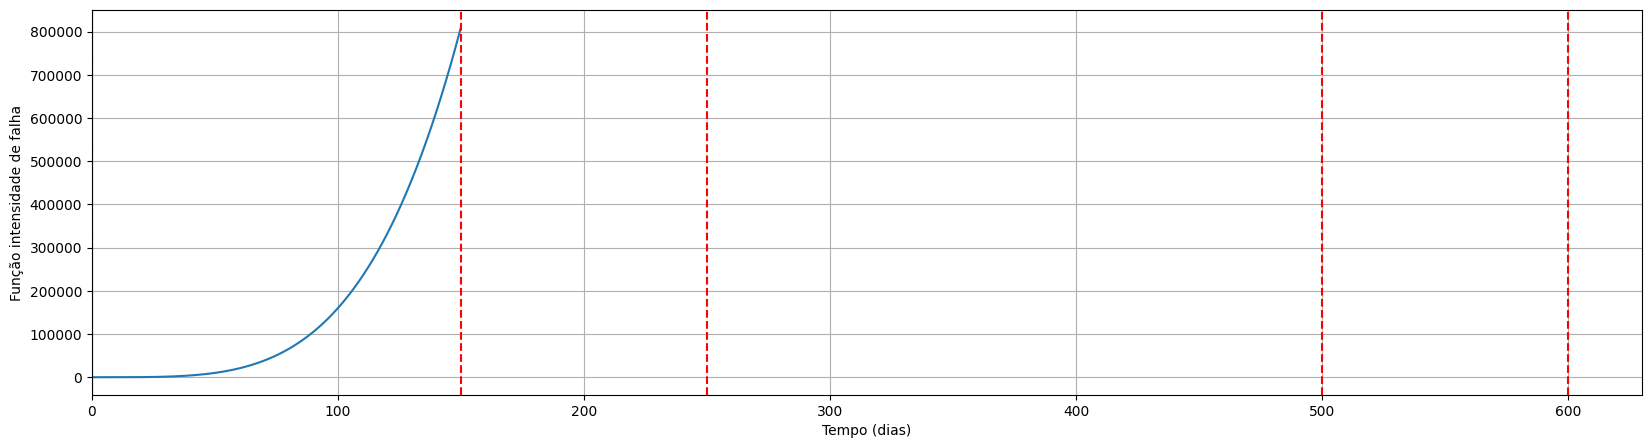

Fator ajuste:  [0.5506710358827784, 0.6321205588285577, 0.8347011117784134, 0.3296799539643607]


In [71]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

# Criação de variáveis para os parâmetros
lamb = 5
theta = 2

# Cria alguns cenários de teste
beta = 5

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [72]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = 730
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [73]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-09-24 04:04:41,634 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=6.85e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 12, 288, 315, 337, 442, 602, 672, 716]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 79.62624000000001, 591666403.3396657, 600685998.1895046, 602279144.5711471, 794323198.790417, 1161583270.9816508, 1664194117.6946077, 1727746191.1633117, 2577528297.7295575]
Custo =  303991235853.71094


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 92, 164, 241, 287, 331, 563, 586, 611, 658]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.75, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693

pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 13, 62, 90, 313, 333, 372, 415, 429, 453, 575, 628, 647, 679, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 205012.14101114956, 569842.0355775259, 353151542.0615848, 354492650.8461973, 506956907.9753716, 767461849.9231063, 867955323.5090832, 1079586380.3055348, 1252990227.000389, 1304546896.6519022, 2011568125.0466053, 2226431184.4159455, 4461588600.092958, 4555207215.853202]
Custo =  553355855504.5177


Número de ciclos de manutenção: 10 5
Tempos para manutenções preven

pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=4.67e+10<ipython-input-72-32b84bde5f7e>:83: RuntimeWarning: divide by zero encountered in double_scalars
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 127, 153, 213, 258, 288, 418, 426, 456, 536, 568, 626, 693]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 6139238.62493534, 8986386.516337968, 11337445.138957316, 19533101.025647268, 20978437.304481372, 250721111.79383528, 258662663.2745998, 528392595.21248525, 784588143.4502957, 802380135.8552063, 2630320764.104877, 5795968069.102183, 6129957212.247002]
Custo =  415003233412.45886


Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 40, 136, 182, 219, 296, 355, 364, 446, 456, 484, 

pyswarms.single.global_best:  67%|██████▋   |67/100, best_cost=4.67e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 15, 39, 146, 287, 342, 412, 442, 460, 529, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.5, 0.5, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 243.00000000000003, 14866.998942658187, 8434448.399749871, 210663360.95004123, 217967379.0435811, 300004244.97896546, 337551937.9562463, 362663422.2600612, 563772379.4597158, 1127487081.8720126, 3330572747.1571107]
Custo =  285439008878.709


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 40, 212, 252, 334, 411, 456, 528, 566, 578, 629]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.

pyswarms.single.global_best:  76%|███████▌  |76/100, best_cost=4.67e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 162, 182, 285, 457, 545, 598, 698]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.5, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 19349.176320000002, 24423450.074157763, 28893830.041580822, 73837332.83737661, 590184526.6831136, 899880659.0038843, 943303962.1811033, 1852024106.7827642, 3764941564.321007]
Custo =  308242228591.2162


Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 20, 37, 281, 356, 428, 459, 596, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.39

pyswarms.single.global_best:  84%|████████▍ |84/100, best_cost=4.67e+10



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 36, 244, 279, 385, 416, 463, 516, 702]
Severidade para cada subsistema: [0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 19349.176320000002, 215702041.90860462, 258648529.32750028, 381512345.5716474, 412339699.37670213, 853874497.4852664, 985772562.579775, 1771721770.9003005, 3450978886.3483486]
Custo =  322000166333.7531


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 12, 36, 176, 205, 257, 345, 385, 414, 459, 703]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 

pyswarms.single.global_best:  91%|█████████ |91/100, best_cost=4.67e+10



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 37, 226, 278, 392, 480, 621]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.5, 0.75, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577]
Media de falhas:  [0, 22190.06624, 142976767.03065425, 204817176.8132655, 258609404.0475336, 310197637.6696422, 1289043376.102667, 1570265635.4189405]
Custo =  50105970423.076035


Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 37, 225, 303, 481, 570, 708]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.75, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 22190.06624, 139664669.04571128, 269721031.6268147, 555269255.57844, 925500677.9010836, 1334502383.3675835,

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=4.67e+10
2023-09-24 04:04:43,128 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.57151344 1.33831874 3.30085342 4.13233124 5.61994665 5.88486881
 0.41458247 4.56642085 2.24877072 3.61655632 1.81538    1.68281697
 2.00568044 1.7657283  0.39195076 4.76760543 5.15813586 2.92220746
 1.52199437 1.66855898 3.29130723 2.26840236 2.69823486 4.24459761]
2023-09-24 04:04:43,130 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 2, 35, 87, 207, 304, 338, 426, 461, 570, 690]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.01024, 15282.421004491142, 382927.8759370972, 49509080.79219028, 98494917.22167405, 189247775.6975416, 317883276.3140712, 644895699.456162, 1137029769.7409213, 1421673796.9947076, 1785386539.335053]
Custo =  121503806394.88327


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.46394109 1.33357108 3.29949798 4.1399253  5.61979648 5.88483419
 0.41214858 4.56988365 2.25100489 3.61662606 1.82299104 1.74027314
 1.99678467 1.76611454 4.11526872 4.76760883 5.16711079 2.92428249
 1.53929195 1.66691997 3.29175247 2.27261782 2.69822083 3.85675057]
2023-09-24 04:04:43,145 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 18, 35, 76, 200, 269, 292, 305, 349, 365, 399, 460, 570, 695]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 604.6617600000001, 7161.15385476289, 152298.48080182154, 45649996.73247783, 63813028.363290414, 98354459.10442066, 122052213.0265817, 146119113.2271114, 155038772.23327062, 332499512.9671376, 884211559.4550462, 1382950667.0739646, 1698693323.205627, 2013113922.0500906]
Custo =  141482160722.94293


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,162 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.43168038 1.3295333  3.29887906 4.14155782 5.61979649 5.88495967
 0.41237146 4.57453035 2.25277368 3.61597734 1.82227816 1.71813882
 2.00002853 1.76525715 4.5407187  4.76759637 5.16760058 2.91115611
 1.54236976 1.66673155 3.29144348 2.273791   2.69793883 6.48619281]
2023-09-24 04:04:43,163 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 35, 65, 179, 185, 266, 283, 359, 373, 412, 457, 565, 570, 626]
Severidade para cada subsistema: [0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 16807.0, 154279.76232841707, 27327219.29127838, 27543762.158980917, 108006058.44385424, 130750248.88769445, 381144252.05236584, 389565209.8456999, 619973449.0379621, 1021756429.8116407, 1492402515.424588, 1494590061.186561, 3262076394.3262463, 4390729175.610363]
Custo =  274213468073.05804


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,173 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.74434986 1.32696012 3.29863227 4.14155621 5.61983151 5.88505714
 0.4127842  4.57824317 2.25414753 3.61541898 1.82006555 1.68825365
 2.00412441 1.76451934 5.90938776 4.76758769 5.16722045 2.90060441
 1.54081221 1.66688561 3.29112768 2.27397303 2.69769997 1.22569277]
2023-09-24 04:04:43,174 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 37, 145, 177, 264, 275, 382, 408, 454, 512, 559, 616, 718]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.25, 0.5, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 22190.06624, 13237330.631750584, 19498710.39468428, 29831315.459323354, 31794369.352084395, 482844728.497016, 506289900.0792775, 905829413.7387514, 1048841424.9030477, 1077492082.4734244, 2761941261.6101694, 8220825365.740709, 8323170840.897531]
Custo =  436371890225.2943


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.43995202 1.32627543 3.29892061 4.13902921 5.61989472 5.8851126
 0.41357153 4.57835883 2.25491588 3.6149672  1.81704135 1.66068539
 2.00784491 1.7640215  0.18336097 4.76758317 5.16470851 2.89417055
 1.53492489 1.66735837 3.29085343 2.27335998 2.69753762 3.61400456]
2023-09-24 04:04:43,190 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 27, 39, 138, 263, 271, 392, 425, 480, 553, 605, 693]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 4591.65024, 11874.920454055766, 5998633.278571116, 131383524.4214359, 131582747.4654234, 698794927.1221538, 734758442.4150532, 839804243.0423666, 895933037.981036, 939891177.6795679, 5047783083.93479, 5381772227.079608]
Custo =  264392890975.0694


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,201 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.1506351  1.3256667  3.29926603 4.13638318 5.61996658 5.88516015
 0.41434518 4.57705461 2.25552648 3.61466719 1.81394657 1.63832668
 2.01073438 1.76382375 2.73575562 4.76758101 5.1614679  2.89120254
 1.52683941 1.66806262 3.29064366 2.27145619 2.69748156 5.90557859]
2023-09-24 04:04:43,202 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 19, 41, 132, 150, 263, 272, 326, 487, 518, 547, 696]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.75, 0.5, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 792.3516800000001, 16867.933365019428, 4315743.517192791, 6164809.879725381, 27723167.169079963, 38160205.89059378, 160167849.6800922, 712154692.3245072, 1177751071.4405885, 1191367170.6153605, 2772010129.2621956, 4801243111.676212]
Custo =  371878025083.65796


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,216 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [5.23551749 1.32859087 3.29986867 4.13343424 5.62003029 5.88519747
 0.41508951 4.57384821 2.25464806 3.61483783 1.81150653 1.62261627
 2.01247169 1.76418986 5.84138684 4.76758003 5.15757975 2.89099551
 1.51874472 1.66871846 3.29064246 2.26958609 2.69747498 0.80009254]
2023-09-24 04:04:43,217 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 4, 43, 127, 197, 266, 274, 316, 493, 543, 594, 657, 717]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.75, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 0.32768, 40258.56412538623, 3211057.006483329, 24330476.34144077, 30162452.737562492, 30370287.707258303, 114957392.32520075, 802131464.3992131, 1694446941.4948106, 1734487800.1404498, 4140006387.2703943, 7407958077.931704, 8197748825.652762]
Custo =  713522241748.3113


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.38427049 1.33262545 3.30043781 4.13047218 5.62007081 5.88518799
 0.41568994 4.57075113 2.2530066  3.61504509 1.81032279 1.61796838
 2.01208525 1.76481052 2.47856034 4.76758428 5.15418431 2.89269907
 1.51191717 1.66926566 3.29080604 2.26774148 2.69759216 3.12757766]
2023-09-24 04:04:43,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 44, 124, 209, 277, 307, 409, 438, 498, 511, 542, 582, 652, 713]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.75, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 52773.19168, 5081833.948441763, 38086780.97375035, 44350829.69135947, 53611252.16419776, 194531333.816485, 416426008.7693305, 1165121079.72478, 1169126204.362325, 1183484556.2046022, 1209754356.9054916, 3789431053.8071985, 7035440368.070587, 8064579251.589237]
Custo =  697583577463.6663


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [6.83644184 1.33775927 3.301042   4.12833804 5.620105   5.88508789
 0.41597328 4.56673676 2.2508418  3.6152435  1.80949978 1.6177607
 2.01041296 1.76562588 6.87641569 4.76759344 5.15177774 2.90052931
 1.50671634 1.66970873 3.29096773 2.26617878 2.69787519 5.25558197]
2023-09-24 04:04:43,251 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 44, 124, 205, 281, 301, 352, 398, 501, 522, 544, 571, 651]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 52773.19168, 5081833.948441763, 34075784.26412023, 42569197.61568914, 76695936.87790558, 106778598.75529386, 341384808.30140066, 1629526528.7018642, 1958440200.9873228, 1967873274.3146532, 1982459188.36108, 4894933440.752835, 9468369697.080976]
Custo =  525461616218.7944


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,269 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.96865132 1.34242975 3.30158177 4.12740211 5.62010902 5.88493869
 0.41621488 4.56310689 2.24866485 3.61564765 1.81007014 1.63051462
 2.00837296 1.76636303 3.40199304 4.76760431 5.15105291 2.90811257
 1.50427479 1.66996421 3.29117584 2.26486995 2.69818135 0.01975526]
2023-09-24 04:04:43,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 21, 44, 62, 125, 287, 343, 503, 520, 547, 651, 710]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702]
Media de falhas:  [0, 1306.9123200000001, 23551.123178081485, 76245.2395104031, 3350143.1404733118, 127824474.85297693, 135455204.3498951, 739498915.9420248, 1002905938.5716276, 1015330425.2974852, 1195546578.1743762, 4286228449.516865, 5493819986.21039]
Custo =  540749520845.0029


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,287 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.98035178 1.34594923 3.30204234 4.12721308 5.62009615 5.88478834
 0.41622054 4.55995115 2.24671111 3.61605999 1.81203388 1.64488793
 2.00636559 1.76687412 0.62324589 4.76761432 5.15213964 2.9168778
 1.50522666 1.67011671 3.29138436 2.26447524 2.69847203 2.29067367]
2023-09-24 04:04:43,288 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 14, 43, 68, 127, 186, 292, 336, 420, 502, 551, 652, 705]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.75, 0.75, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 172.10368000000003, 26812.99750696554, 134237.15867546937, 3335291.0868233964, 7490254.249231994, 29793911.29793598, 50689650.75529547, 164870177.28434247, 1207194291.7806516, 1236180333.163016, 1407432793.7334495, 4116915952.608922, 5619995227.543247]
Custo =  513673594785.66925


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,304 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [5.46367583 1.34830081 3.30231186 4.12799818 5.62006032 5.88466045
 0.41575988 4.55743733 2.24530503 3.61656215 1.81457633 1.66547705
 2.00444035 1.76712564 5.78155651 4.76762281 5.15422554 2.92498897
 1.51071429 1.66988679 3.29155245 2.26519988 2.69867556 4.75129651]
2023-09-24 04:04:43,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 11, 41, 74, 129, 170, 296, 303, 331, 498, 556, 606, 653]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 51.53632, 23377.531779548037, 227984.93068808713, 3351064.4047391945, 5007035.982609027, 42867173.19891384, 55446396.678542435, 66825231.954625055, 2115153833.4614844, 3246912732.3220053, 3288635575.8795433, 5059997043.489405, 5831984978.391934]
Custo =  331741572072.1842


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.67746523 1.3494238  3.30224606 4.12870488 5.6200184  5.88459096
 0.41508596 4.55645824 2.24427927 3.61701275 1.81687836 1.68550054
 2.00292561 1.76720142 4.31480853 4.76762554 5.15715444 2.93181513
 1.51835154 1.66955899 3.29167479 2.26643779 2.69880546 6.91394482]
2023-09-24 04:04:43,321 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 16, 41, 79, 133, 173, 299, 308, 331, 389, 492, 525, 560, 616, 658]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 335.54432, 18911.79811317351, 330129.0888688202, 3767824.6138522024, 5457774.373261163, 44095449.30010608, 46577798.55936355, 55658523.249873415, 322529316.3301048, 1519977648.1479764, 2042103736.6950753, 2061131251.3787308, 2337533728.2097416, 3976431393.9176083, 4688266684.308429]
Custo =  350113817012.0827


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,334 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.1665503  1.34727548 3.30202082 4.12971891 5.61996904 5.88453897
 0.41434597 4.55615102 2.24360009 3.61730026 1.81893279 1.7034764
 2.00174216 1.7671337  3.33027405 4.76762385 5.15979677 2.93539526
 1.52585901 1.66910992 3.29170566 2.26779368 2.69890196 1.26663184]
2023-09-24 04:04:43,335 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 28, 39, 82, 138, 195, 315, 334, 384, 399, 484, 562, 571, 625, 705]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 5507.317760000001, 12243.13373606611, 430894.16874641005, 4562673.808357177, 9106188.499955624, 46456720.218160786, 47723614.114032365, 267512205.1737767, 347837047.6494814, 1278745231.8620715, 2847297845.083503, 2851407723.6168423, 4547316931.641972, 8567569897.270764, 8786972721.055012]
Custo =  528983586403.4193


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 38, 84, 143, 153, 321, 341, 381, 412, 564, 584, 704]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 25355.253760000003, 618731.7001090619, 5650475.875372857, 5829335.903519021, 113808496.34192345, 170257832.5445282, 342311783.2448405, 527149439.10753417, 3570308194.7022686, 4062837211.5127487, 9952488618.829323, 11514384694.057936]
Custo =  670585507986.3821


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,352 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [5.25691976 1.34418491 3.30150653 4.13127913 5.61992271 5.88455924
 0.41374602 4.55622671 2.24348986 3.61754451 1.82011636 1.7156893
 2.00098139 1.76676468 2.55212457 4.76761988 5.16190162 2.93606616
 1.53241762 1.66854175 3.29171752 2.26902758 2.69890634 2.6904205 ]
2023-09-24 04:04:43,354 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 38, 81, 146, 194, 326, 347, 379, 565, 597, 629, 700]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 25355.253760000003, 503561.16166412487, 6608234.388438146, 9948386.263202123, 62854099.70153794, 72703925.31136486, 208722836.37056, 3984066295.9964137, 4834952298.982825, 5885084750.030434, 9370135497.553226, 9636472301.014757]
Custo =  571852847026.3601


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,366 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.89379159 1.34068978 3.30085988 4.13297611 5.61988461 5.88460197
 0.41336419 4.55694653 2.24471404 3.61759214 1.82065368 1.71864247
 2.00075188 1.76623507 2.4509539  4.76761356 5.16371195 2.93324012
 1.53631325 1.66803225 3.29167269 2.27008184 2.6987184  4.27910418]
2023-09-24 04:04:43,367 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 9, 38, 77, 148, 207, 296, 353, 380, 422, 450, 538, 563, 628]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 16902.43277188177, 150294.51654114472, 7308308.842449227, 13168311.917990439, 27550112.492517605, 36173981.81032579, 54745809.58942138, 327275335.62462467, 566485694.8993694, 2042060637.3195324, 2054625702.5557656, 4119660884.1152134, 9957065638.210548]
Custo =  490026537487.74756


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,379 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.73635738 1.33698482 3.30027667 4.13431788 5.61986076 5.88468442
 0.41336991 4.55915612 2.24617964 3.61752947 1.82061506 1.71674784
 2.0007331  1.76571849 2.75129969 4.7676078  5.16525185 2.93004709
 1.53937298 1.66765698 3.29160523 2.27094318 2.69844621 5.7044861 ]
2023-09-24 04:04:43,380 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 13, 37, 72, 292, 358, 383, 450, 559, 625]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 118.81376000000002, 12093.001922857047, 98808.89090319727, 407855553.9937839, 453472908.0737294, 471028448.4573644, 1023139693.4282417, 3139307252.234692, 3210415284.1142406, 9211727704.771112]
Custo =  356549670866.39246


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [6.09966514 1.33385454 3.29988188 4.13504951 5.61985217 5.88479241
 0.41368143 4.56303479 2.24825836 3.6174576  1.81987177 1.70814324
 2.00099411 1.76525482 3.62965546 4.76760224 5.16610746 2.92706069
 1.53805412 1.66749027 3.29146764 2.27130937 2.69817793 6.93208666]
2023-09-24 04:04:43,395 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 16, 38, 67, 149, 155, 287, 386, 431, 556, 620, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 335.54432, 12300.499991466088, 59059.886076465795, 8900619.626654312, 9008449.115214165, 50044369.27527137, 484805082.32290035, 539505890.8518, 2905727329.271238, 4837576302.45321, 9542668917.704647, 9707187769.649893]
Custo =  462096240769.2119



2023-09-24 04:04:43,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.02924212 1.33233077 3.29965839 4.13495918 5.61987272 5.88490066
 0.41415263 4.56673547 2.25020276 3.61723314 1.81909038 1.70027144
 2.00255715 1.76486703 4.94227694 4.76759775 5.16674731 2.92315105
 1.5362271  1.66747657 3.29133525 2.27122255 2.69794696 0.53788442]
2023-09-24 04:04:43,413 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,425 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.80231374 1.33271361 3.29950095 4.13411972 5.61989312 5.88499394
 0.41460263 4.5700398  2.25163791 3.61686891 1.81759433 1.68978781
 2.00405475 1.76476017 5.93129779 4.76759517 5.16600969 2.91950315
 1.53381419 1.66765755 3.29120844 2.27094584 2.69781619 1.25839978]
2023-09-24 04:04



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 9, 38, 62, 146, 283, 389, 428, 552, 614]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 18.895680000000002, 16902.43277188177, 42018.25503342546, 8527480.002327444, 89112008.76311812, 133096122.21053337, 177976238.62423134, 2458480854.1718836, 2519069342.0450764, 9120337060.015505]
Custo =  314129814746.9174


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 39, 141, 269, 280, 482, 510, 550, 597, 609, 710]
Severidade para cada subsistema: [0.25, 0.75, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 11081412.510836437, 151638057.0782683, 151967017.2504492, 2381144486.5828648, 2441808232.259927, 2463236447.8246045, 2663078855.8263855, 3015765954.073382, 8183908216.378006, 8357469332.3085985]
Custo =  433860966916.3594


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [6.89855802 1.33434131 3.299604   4.1330094  5.61992206 5.88507042
 0.41500706 4.57287149 2.25226645 3.61653149 1.81610112 1.67942098
 2.005622   1.76490734 6.11104108 4.76759302 5.16313311 2.91664709
 1.53097012 1.66783877 3.29109541 2.26998103 2.69778466 1.94582189]
2023-09-24 04:04:43,446 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.86773174 1.33620896 3.29983434 4.13187853 5.61994847 5.88510604
 0.41524885 4.57483919 2.25183926 3.61623438 1.81456792 1.67013032
 2.00704676 1.76526836 5.93844934 4.76759224 5.15976248 2.9151661
 1.52696171 1.668



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 40, 137, 183, 278, 487, 516, 548, 591, 604]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 9338934.781771233, 19544632.136802144, 34305303.747767344, 965785600.0732273, 1031778687.1994774, 1047370874.83783, 1220979285.4155006, 1590227188.491421, 8736229519.740892]
Custo =  387396459292.812


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,474 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.37578157 1.33847979 3.30026233 4.13088548 5.61997222 5.88508633
 0.41544069 4.57578484 2.25062321 3.61599911 1.81326841 1.66353956
 2.00794273 1.76568483 5.49890413 4.7675929  5.15661718 2.91496277
 1.52228473 1.66837335 3.29103186 2.26742132 2.6979376  3.78439373]
2023-09-24 04:04:43,475 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 41, 134, 152, 276, 419, 490, 520, 546, 585, 601, 707]
Severidade para cada subsistema: [0.25, 0.75, 0.5, 0.5, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 37073.98432, 8156264.666124978, 10107103.18278831, 41517916.726337366, 317867910.56623757, 475131916.5238597, 933246254.679158, 945010462.2668537, 1094457357.473368, 1538504453.1214523, 6859004491.704952, 7059942749.267034]
Custo =  443340437443.63995


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 41, 131, 178, 182, 274, 355, 410, 435, 492, 520, 545, 580]
Severidade para cada subsistema: [0.25, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 37073.98432, 7193942.02567842, 16528148.852278534, 16547621.792801267, 29635071.759198926, 284392973.2608916, 342706630.0141038, 529683978.8514706, 1208478230.596554, 1219264368.7113883, 1230386633.378248, 1358482145.9517088, 9814478034.663279]
Custo =  339530435656.2829


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,493 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.13367417 1.3404874  3.30069268 4.1300464  5.61998812 5.88504167
 0.41560244 4.57631463 2.24951208 3.61591413 1.81217597 1.66097249
 2.00860111 1.76606215 4.30000846 4.76759484 5.15387888 2.91625732
 1.518032   1.66866026 3.29106915 2.26657007 2.69810039 4.91730797]
2023-09-24 04:04:43,494 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,512 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [5.53960613 1.34183959 3.30109654 4.1293975  5.61999235 5.8849545
 0.41572544 4.57406369 2.24838072 3.6159317  1.81173368 1.65931181
 2.0086323  1.7663775  2.98694039 4.76759756 5.15261865 2.91851057
 1.51511319 1.668



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 25, 41, 61, 130, 165, 188, 276, 351, 402, 430, 493, 518, 545, 576]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 3125.0000000000005, 14772.902067950688, 69916.12270381213, 4329723.596548058, 5496877.461625058, 5720281.951716357, 107248860.19706151, 158661323.76568854, 207851722.6580931, 406980761.13107014, 1160002171.6118164, 1537920594.3765545, 1550176548.8270187, 1659246004.326884, 10334533540.115784]
Custo =  389594788591.31995


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,530 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.9449587  1.34262498 3.30143194 4.12891946 5.61998966 5.88487046
 0.41553056 4.57134254 2.24739936 3.6159607  1.81195499 1.66108322
 2.00858917 1.76652526 2.04590475 4.76760129 5.15168622 2.92070458
 1.51312948 1.66911967 3.29124798 2.26621003 2.69842264 6.46885484]




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 22, 41, 64, 130, 206, 280, 327, 347, 398, 492, 514, 547, 575, 659]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666]
Media de falhas:  [0, 1649.16224, 15432.435286261049, 92809.45808047873, 4113425.9209899795, 13348305.630084574, 21233605.808766168, 25961152.679888226, 35293078.8596746, 294190369.41542584, 1390060421.5851693, 1713500561.2770617, 1729635620.0178757, 1826586290.2511406, 5032485436.829466, 9161950391.923725]
Custo =  530300715700.1748


2023-09-24 04:04:43,531 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.50951285 1.34250952 3.30162194 4.12861505 5.61997511 5.88479438
 0.41514388 4.56850173 2.24678376 3.61600844 1.81257098 1.6631264
 2.0083495  1.76645122 1.89281465 4.76760471 5.15086119 2.92297831
 1.51337515 1.66914568 3.29134592 2.26664291 2.69851897 6.75818175]




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 20, 41, 67, 132, 189, 285, 323, 344, 395, 491, 550, 578, 602]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 1024.0, 16314.716074443764, 122255.54242546097, 4296399.63324984, 8404188.375692235, 24477010.697674137, 108480333.60049587, 118003075.67013991, 369096175.9153126, 1478361402.030379, 2579382346.5795536, 2595365004.3982983, 3260441830.821928, 10515393409.635113]
Custo =  492295625102.6068


2023-09-24 04:04:43,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 22, 40, 70, 136, 289, 320, 342, 397, 490, 553, 582, 606, 715]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 1649.16224, 13476.617516781609, 161308.17158649827, 4919367.506746484, 115218830.73877972, 117401928.34591305, 127206930.78831875, 402642015.82261384, 1469573151.8243752, 2667888783.151046, 2685035134.017051, 3368072749.6146016, 9086855345.111403, 9215610456.735638]
Custo =  507666652500.13635


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.22805955 1.34178077 3.30176068 4.12893681 5.61995526 5.88473563
 0.41465603 4.56577303 2.24681769 3.61614362 1.81378665 1.66627839
 2.00784539 1.7662393  2.09838505 4.76760799 5.15190138 2.92489737
 1.51593421 1.66910092 3.29143176 2.26703765 2.69858974 6.84323779]
2023-09-24 04:04:43,567 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,580 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.34127289 1.34036989 3.30172449 4.12939073 5.61993703 5.88468355
 0.41419751 4.56332691 2.24742052 3.61635327 1.81507265 1.67228389
 2.00677459 1.76600839 2.7947689  4.76761088 5.15423002 2.92611165
 1.51895879 1.66



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 29, 40, 73, 139, 293, 318, 341, 388, 400, 488, 556, 588, 610]
Severidade para cada subsistema: [0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 6563.56768, 14037.5123646409, 208341.84452261144, 5372674.641730962, 121499662.92399554, 123046964.31366675, 133236985.3523976, 349287449.1194907, 414496985.0900045, 1409514172.349622, 2727012549.9830685, 2747230406.131027, 3391415684.192931, 10210602557.161648]
Custo =  515185998792.1183


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 74, 142, 295, 317, 342, 385, 404, 486, 559, 593, 613, 704]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 298406.42278585624, 6105522.419792096, 122513832.3804501, 123790283.67884412, 135116297.09814668, 327437138.7860553, 433784446.1098764, 1348224236.1245341, 2789087414.103576, 2811670366.0364294, 3410157176.097606, 7930650204.776373, 8159350615.476542]
Custo =  525542252682.70087


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [6.58827242 1.33854486 3.30156521 4.13027027 5.61992133 5.88464333
 0.41379013 4.56117013 2.24820165 3.6166017  1.81626724 1.68042509
 2.00566905 1.76576289 3.56298934 4.76761211 5.15659521 2.92650265
 1.52218541 1.668777   3.29151426 2.26841674 2.69860844 6.06294765]
2023-09-24 04:04:43,597 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,611 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [5.83011946 1.33688301 3.3012995  4.13167559 5.61991219 5.88461219
 0.41345441 4.5595631  2.24899276 3.61682399 1.8171157  1.68846335
 2.00467607 1.76553548 4.58070144 4.76761198 5.15881564 2.92669314
 1.5250477  1.66



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 75, 144, 297, 317, 344, 383, 410, 421, 483, 561, 597, 615]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 321510.9767418206, 6554006.899093864, 125057116.2119926, 126177231.63319615, 138827243.2766896, 310358868.35890806, 469006295.0794215, 542536890.9102591, 1225144219.4502735, 2782437954.1753187, 2807409216.9756103, 3354250529.572819, 9901025226.040298]
Custo =  549336888280.39355


2023-09-24 04:04:43,612 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,626 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.62940241 1.33571109 3.30095508 4.13303269 5.61990645 5.88462915
 0.41332843 4.5581304  2.24969935 3.61696717 1.81777227 1.69497207
 2.00406813 1.7653461  5.70699124 4.7676112  5.16068973 2.92646719
 1.52687131 1.66839447 3.29150562 2.26945729 2.69847293 4.05585309]
2023-09-24 04:04:43,628 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 75, 145, 154, 297, 319, 345, 384, 416, 481, 562, 615, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 28871.743680000003, 321510.9767418206, 6833759.202649956, 6996906.523791731, 63144979.14719241, 110439801.02826826, 122690112.68560125, 296039860.9441862, 494192360.1019127, 1196414862.9970477, 2822549538.941843, 2870451762.821276, 7744977315.791071, 7918538431.721663]
Custo =  422170243394.6033


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,640 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.00441515 1.33490071 3.30062731 4.13408376 5.61990266 5.88471587
 0.41345608 4.55746076 2.25030519 3.61707179 1.81768235 1.69896366
 2.00398814 1.76525709 6.96326009 4.76760961 5.16220137 2.92588966
 1.5279275  1.66827832 3.29143605 2.26957232 2.69836022 3.11532695]
2023-09-24 04:04:43,642 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 39, 75, 145, 163, 296, 321, 347, 385, 426, 480, 561, 613, 706]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666]
Media de falhas:  [0, 28871.743680000003, 321510.9767418206, 6833759.202649956, 7286970.949891744, 51866639.85861404, 53466491.96007376, 65992992.73674211, 236875109.71641427, 513544360.3395502, 1096899829.2707524, 2711363547.78922, 2757398458.263389, 7425969075.247597, 7636117999.86693]
Custo =  411314729625.59753


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 0, 39, 73, 143, 292, 324, 348, 387, 480, 559, 610]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.0, 28871.743680000003, 113207.23783021998, 6295228.035038869, 112746226.7928964, 115140347.14791815, 126706420.20576209, 305597542.0842983, 1287379630.1070285, 2841130220.695054, 2885095844.6944637, 9704282717.66318]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.00441515 1.33490071 3.30062731 4.13408376 5.61990266 5.88471587
 0.41345608 4.55746076 2.25030519 3.61707179 1.81768235 1.69896366
 2.00398814 1.76525709 6.96326009 4.76760961 5.16220137 2.92588966
 1.5279275  1.66827832 3.29143605 2.26957232 2.69836022 3.11532695]
2023-09-24 04:04:43,659 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.61458006 1.33574879 3.30030734 4.13426468 5.61991503 5.88490115
 0.41407943 4.55830767 2.25048072 3.61711146 1.81663338 1.69380221
 2.00480287 1.76540809 4.52512887 4.76760447 5.16143549 2.92458433
 1.52770183 1.66



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 1, 39, 72, 142, 289, 325, 350, 388, 480, 557, 599, 608, 697]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 0.00032, 27671.889501280548, 103619.65249980113, 6125514.575293542, 106467337.19821392, 109388826.27442944, 121773249.69909717, 298102897.4088439, 1269678747.8812723, 2764014363.2057333, 2795206818.28404, 3058837181.315796, 7309096754.499175, 7604142133.525174]
Custo =  490749746311.7337


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.61458006 1.33574879 3.30030734 4.13426468 5.61991503 5.88490115
 0.41407943 4.55830767 2.25048072 3.61711146 1.81663338 1.69380221
 2.00480287 1.76540809 4.52512887 4.76760447 5.16143549 2.92458433
 1.52770183 1.66819723 3.2912891  2.26934839 2.69818097 2.27598817]
2023-09-24 04:04:43,687 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 0, 40, 70, 140, 285, 327, 351, 389, 419, 438, 481, 555, 597, 607]
Severidade para cada subsistema: [0.5, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 0.0, 32768.0, 89750.99793316927, 5801133.020639436, 99440777.37170783, 103308549.27423966, 115265475.68791458, 293439647.0028013, 485137547.79837656, 632376003.659047, 1105452579.3127098, 1368421392.29137, 1399240018.727348, 1689918557.145848, 8672513563.58891]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 166, 202, 283, 327, 351, 416, 481, 553, 594, 606]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 6462537.2802609205, 7105412.668232738, 110002955.285743, 114200517.47648765, 126157443.89016259, 516527995.9248639, 1218750498.8199987, 2580021794.856442, 2609287173.624522, 2955054004.745796, 9992117059.338354]
Custo =  495960489383.4935


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,702 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.37397575 1.33779685 3.30032066 4.13299369 5.61993751 5.88498188
 0.4146649  4.56070417 2.2498132  3.61697157 1.81542167 1.68098458
 2.00575656 1.76574051 4.85440061 4.76760145 5.15843223 2.92335515
 1.52380528 1.66834551 3.29119244 2.26889105 2.69811364 2.52805268]
2023-09-24 04:04:43,703 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 40, 66, 136, 174, 201, 282, 327, 352, 412, 448, 483, 553, 591, 605, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 159809.1934959813, 5287817.474901908, 6879277.7912743855, 7246500.324650074, 35116368.985850655, 54569102.84171438, 67229366.35103709, 414978628.9137243, 714314093.3340727, 1109048749.0214949, 2434196523.0312557, 2460082008.2978854, 2859956930.7347713, 7535839780.888659, 7792699658.71541]
Custo =  530179050887.63055


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,720 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [0.49165319 1.33852596 3.3004795  4.13234066 5.61994967 5.88498306
 0.41484946 4.56364115 2.24935474 3.61680265 1.81497144 1.67631567
 2.00608341 1.76588234 1.86136484 4.7676008  5.15728024 2.92256066
 1.52137637 1.66842743 3.29116771 2.26871636 2.69811338 3.03926536]
2023-09-24 04:04:43,721 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.22081021 1.33917985 3.30064697 4.13175282 5.61996006 5.88496119
 0.41499564 4.56691554 2.24890681 3.61659873 1.81461947 1.6738369
 2.00634115 1.76600664 5.96120792 4.76760057 5.15630321 2.92178303
 1.51932478 1.668



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 65, 135, 191, 281, 327, 352, 409, 484, 512, 552, 587, 606, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 147824.38084768332, 5137566.121622137, 9255709.011147639, 22337556.015915327, 128298442.75870365, 140958706.26802635, 462433402.6090228, 1288068590.2326052, 1690598865.24581, 1712308205.6416512, 1846524852.4081943, 2389986175.181278, 7470371335.323942, 7671309592.8860235]
Custo =  504591892133.77747


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,746 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.15872721 1.33975843 3.30085854 4.13126227 5.61996574 5.88493461
 0.41504178 4.56972383 2.24850317 3.61640991 1.81438048 1.67205345
 2.00650554 1.76608278 3.25634362 4.767601   5.15561065 2.92115553
 1.51772824 1.66863695 3.29112969 2.2683312  2.69815554 4.31189327]
2023-09-24 04:04:43,747 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 65, 135, 281, 327, 352, 406, 486, 515, 552, 584, 606, 707]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 147824.38084768332, 5137566.121622137, 96811058.91746671, 101357097.23040882, 114017360.73973152, 410357596.7326257, 1303396374.8259833, 1729776109.777535, 1749253082.2536397, 1868434473.663724, 2495797906.107502, 7576183066.250166, 7777121323.812247]
Custo =  497871961322.1448


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 40, 64, 135, 170, 281, 326, 351, 405, 424, 487, 515, 553, 582, 607, 701]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 136729.9414160896, 5219655.215772896, 6514965.329420514, 29937087.197005887, 49170827.72380374, 61692599.87671521, 355091293.3074273, 484279817.67093474, 1200909254.6372964, 1263927158.4579902, 1284267519.611496, 1389870014.0242064, 2105400884.2595582, 6688218899.160904, 6945078776.987656]
Custo =  470080225506.4301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,759 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.11889813 1.34015676 3.30104799 4.13107394 5.61996991 5.88489351
 0.4150541  4.57187659 2.24815312 3.61624624 1.81436305 1.67089365
 2.0064381  1.76610482 0.56496482 4.76760191 5.15572896 2.92066907
 1.51706505 1.66871113 3.29115046 2.2681724  2.69819955 4.91703126]
2023-09-24 04:04:43,760 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 64, 135, 283, 325, 351, 403, 448, 487, 516, 554, 581, 608, 690]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.75]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702]
Media de falhas:  [0, 32768.0, 136729.9414160896, 5219655.215772896, 101680214.6713218, 105471484.2732688, 118564392.91844904, 395968056.4677615, 766705400.0321231, 1219584438.044163, 1230558052.6431177, 1251031676.2154505, 1348106141.606074, 2124509412.3819602, 5897758132.506741, 6261470874.847086]
Custo =  459536699617.09076


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.83320218 1.34051229 3.30121006 4.1311511  5.619971   5.88484959
 0.41501932 4.57375233 2.24796058 3.61615602 1.81436921 1.67335068
 2.00634511 1.76610781 5.11378338 4.76760281 5.15617153 2.92044636
 1.51677323 1.66875957 3.29121212 2.26807241 2.69824179 5.44377193]
2023-09-24 04:04:43,780 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,791 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.16263461 1.340263   3.30134165 4.13156404 5.61996983 5.88481548
 0.41486307 4.57357518 2.24788108 3.61618453 1.81441835 1.67729854
 2.0061136  1.7660292  2.76391059 4.7676038  5.15706006 2.92027006
 1.51709638 1.66



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 40, 65, 136, 178, 206, 285, 324, 350, 403, 424, 487, 515, 555, 581, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 147824.38084768332, 5371189.250480587, 7383558.715866959, 7807596.099868452, 110969737.78045213, 198166261.412419, 211115798.03932258, 493610455.1853204, 636009456.7881894, 1352638893.754551, 1764759882.3076944, 1786896121.9004238, 1880096942.0506651, 2689825404.6210093, 9563483184.558052]
Custo =  529001803697.12354


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 66, 137, 288, 323, 350, 405, 441, 486, 513, 556, 584, 610, 718]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 5526639.580578508, 111455749.05937622, 114188645.0958652, 127709655.66554534, 426294229.9699159, 707181433.9349679, 1222417170.669044, 1282061283.115265, 1306753013.6696062, 1409782355.49896, 2168110481.0081134, 7933498668.641052, 8035844143.7978735]
Custo =  494335823070.2715


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,808 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [4.0894825  1.33983943 3.30132165 4.13214573 5.61996349 5.88479703
 0.41469987 4.57134359 2.2479224  3.61624701 1.81462512 1.68134475
 2.00588889 1.76594718 0.55621311 4.76760496 5.15805148 2.92066935
 1.51882322 1.66880049 3.29134228 2.2679434  2.69830451 5.79143776]
2023-09-24 04:04:43,809 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,818 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.87947998 1.33909756 3.30117604 4.13267153 5.61995357 5.88478641
 0.41454824 4.56842976 2.24817446 3.61634448 1.81486487 1.6852003
 2.00568178 1.76583317 5.52259088 4.76760611 5.15896684 2.92105429
 1.52130495 1.668



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 139, 290, 322, 349, 389, 409, 485, 511, 557, 586, 610, 704]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5939116.780228487, 113811427.16755787, 116155207.2848423, 129528009.24180184, 316664320.26886, 434127981.8116609, 1277302000.0945823, 1648962951.7787468, 1676371247.189142, 1784842141.901151, 2486202027.5680895, 7148875007.604308, 7377575418.304478]
Custo =  517073034890.6741


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 39, 68, 140, 163, 185, 291, 322, 349, 389, 413, 422, 484, 557, 589, 610, 695]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 188112.2903592485, 6109665.608606082, 6728254.69845081, 6924713.501010086, 57580454.89962627, 69127591.53602609, 82500393.49298564, 269636704.5200438, 415434493.7200531, 476356515.58542293, 1164698965.6347206, 2584821573.8770723, 2605166925.174829, 3220685734.7514095, 7241371701.650354, 7555792300.494818]

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,847 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.43948807 1.33835639 3.3009515  4.13310956 5.61994451 5.88479658
 0.41441732 4.56550194 2.24850178 3.61647618 1.81515338 1.68854431
 2.00549524 1.76571392 2.61080326 4.76760706 5.15956738 2.92161237
 1.52366536 1.66872126 3.29141107 2.26815313 2.69832593 5.45256592]
2023-09-24 04:04:43,851 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 39, 69, 141, 292, 323, 349, 389, 417, 429, 484, 557, 592, 610, 692]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 203451.9627027325, 6283432.852204184, 116127094.94764057, 118381571.17562811, 131188920.18985668, 318325231.21691483, 494255906.5572419, 580643595.2765384, 1194580109.879282, 1456454170.0682623, 1479775063.2297366, 2008969244.0136867, 5826654538.94713, 6170501634.531884]
Custo =  479863651094.0654


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,880 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.8654918  1.33767911 3.30073819 4.13327868 5.61993638 5.88480925
 0.41433948 4.56313631 2.24884764 3.61660831 1.81546582 1.69053185
 2.00535799 1.76561014 6.9594984  4.76760784 5.15984784 2.92220145
 1.52538941 1.6686709  3.29141781 2.26830128 2.69830964 4.90787061]
2023-09-24 04:04:43,881 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 39, 70, 141, 186, 292, 323, 349, 389, 419, 431, 483, 557, 594, 609, 696]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 219924.35794825092, 6191796.855437251, 8801358.344572842, 31105015.39327683, 100250231.89709863, 113057580.91132718, 300193891.93838537, 491891792.7339606, 579908928.2266788, 1156961566.2549467, 1215810569.782124, 1241243682.4393873, 1680705381.0606396, 5815646845.813792, 6120355905.108614]
Custo =  479411768293.1947


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.27605453 1.33715692 3.30054898 4.1332463  5.61992935 5.88482374
 0.41433182 4.56116781 2.24914894 3.61671898 1.81572629 1.69116798
 2.00523792 1.76554761 2.79159099 4.76760814 5.15976686 2.92273256
 1.52632199 1.66859289 3.29140317 2.26845235 2.69827447 4.32396349]
2023-09-24 04:04:43,917 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 39, 71, 141, 158, 199, 291, 324, 349, 388, 482, 557, 595, 609, 703]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 28871.743680000003, 237591.0816140874, 6102622.080388441, 6478287.466850448, 7285908.320260738, 22340798.23643264, 35084442.076115474, 47332653.07999135, 228100156.6757396, 1236865556.4657476, 2694114090.7586865, 2720643341.272475, 3131238871.9106374, 7767178044.237946, 8005220186.809357]
Custo =  496521777456.4606


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.82203575 1.3368771  3.30044626 4.13317491 5.6199242  5.88484673
 0.4143635  4.55965357 2.24937769 3.61680173 1.81588981 1.68970486
 2.00522428 1.76552554 5.62757688 4.76760815 5.15934733 2.92312216
 1.52666027 1.66851884 3.29136183 2.26857567 2.69824138 3.78004433]
2023-09-24 04:04:43,946 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.43235205 1.33665699 3.3003755  4.13300076 5.61992041 5.88487186
 0.41445526 4.55923718 2.24955144 3.61680987 1.81600247 1.68765704
 2.00529006 1.76551572 0.5427441  4.76760742 5.15888462 2.92346754
 1.52644313 1.66



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 71, 140, 201, 290, 325, 349, 389, 433, 482, 557, 595, 608, 710]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 5843150.876392266, 11494492.35359667, 25184069.96221023, 27974561.24471128, 39669834.35906221, 226806145.38612038, 542981431.8077822, 1083611113.8943279, 1354775534.9284291, 1381304785.4422174, 1760466382.029557, 6977485446.139921, 7151046562.070514]
Custo =  468419292448.20044


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:43,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.31358534 1.33669279 3.30037276 4.13281841 5.61991849 5.88489372
 0.41455855 4.56094321 2.24963184 3.61681019 1.81602284 1.68576012
 2.00536741 1.76556788 2.96189637 4.7676064  5.15826736 2.9234888
 1.52584662 1.66842718 3.29128801 2.26873863 2.69818677 3.12742269]
2023-09-24 04:04:43,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 40, 71, 138, 186, 289, 326, 349, 389, 419, 442, 482, 556, 594, 608, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 5356173.733911493, 8255841.483683826, 28377921.13472864, 113388960.04346369, 124537381.37778202, 311673692.4048402, 503371593.2004155, 687289069.7600363, 1132371187.3473697, 1190879360.0970867, 1217246549.9134192, 1625141961.378034, 7325863865.788456, 7445777150.887407]
Custo =  501133074301.725


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 71, 137, 288, 326, 350, 389, 416, 433, 483, 556, 593, 607]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 5125602.84986542, 111054712.32866314, 114282616.05511692, 126108171.60642982, 308766813.92150515, 476991067.1104597, 603125163.4435141, 1158941142.252721, 2568778170.0167055, 2594055256.5490723, 2999263889.5905075, 9981858896.03357]
Custo =  546076925240.6373


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,019 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.36659667 1.33717852 3.30045614 4.13250941 5.6199244  5.88491257
 0.41465485 4.56395756 2.24945208 3.6167888  1.81592846 1.68401827
 2.00544301 1.76561833 5.36106664 4.76760546 5.15770495 2.92337306
 1.52504082 1.66841488 3.29125875 2.26872126 2.69816986 3.00537931]
2023-09-24 04:04:44,020 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 71, 136, 287, 326, 350, 414, 483, 556, 591, 607]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 4903335.034565526, 109871309.41372178, 113243270.56495672, 125068826.11626962, 502268714.8698585, 1258292090.1650317, 2668129117.929016, 2691305721.6288705, 3153429419.069168, 10136024425.51223]
Custo =  495323749701.1539


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,049 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.51309014 1.33765326 3.30063661 4.13219432 5.6199334  5.88492903
 0.41472667 4.56729779 2.24913172 3.61672647 1.81574803 1.68211597
 2.00554761 1.76568992 0.81409843 4.76760462 5.15730607 2.92301906
 1.52374253 1.66841969 3.29123705 2.26864166 2.69816976 2.99813829]
2023-09-24 04:04:44,051 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 71, 136, 167, 196, 286, 326, 351, 411, 484, 555, 589, 607]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 4903335.034565526, 5920968.0200353805, 6306765.5888750255, 125951993.32017581, 142488810.6570149, 155010582.80992636, 499358816.54847586, 1303921287.5575593, 2666896671.5068073, 2688923977.06779, 3207737062.4308276, 10190332068.87389]
Custo =  498264920743.4574



2023-09-24 04:04:44,074 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.73031686 1.33813205 3.30081563 4.13194369 5.61994286 5.88493478
 0.41475551 4.57009138 2.24877548 3.61665045 1.8155186  1.68040987
 2.00565352 1.76576337 3.71254515 4.76760405 5.1569903  2.9226775
 1.5223834  1.66842588 3.29123161 2.26856234 2.69818321 3.33911002]
2023-09-24 04:04:44,075 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 71, 136, 156, 285, 325, 351, 409, 485, 555, 587, 607]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 234999.82464063825, 4903335.034565526, 5342057.790824347, 43068110.168248415, 46552859.09145648, 59645767.73663672, 386505640.2065443, 1229679658.4894657, 2574321841.939639, 2594412805.613327, 3169695306.1297092, 10152290312.572771]
Custo =  492337435400.04755



2023-09-24 04:04:44,095 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.17804514 1.33856403 3.30097888 4.13177167 5.61995169 5.88492713
 0.41475686 4.57227766 2.24845425 3.61656023 1.81530559 1.6789905
 2.00575618 1.76582757 6.89756074 4.76760391 5.15691801 2.92232687
 1.52111019 1.66846648 3.29123947 2.26844807 2.6982046  3.84812429]
2023-09-24 04:04:44,097 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,115 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.64721404 1.33894485 3.30109087 4.13168758 5.61995816 5.88491299
 0.41471332 4.57356975 2.24824909 3.616478   1.81513326 1.67836811
 2.00584769 1.76587629 1.72137923 4.76760416 5.15694414 2.922006
 1.52004536 1.66852665 3.29126322 2.26834282 2.69822638 4.34300135]
2023-09-24 04:04:44



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 137, 168, 285, 324, 351, 407, 486, 555, 586, 607]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5279291.513880441, 6318790.401729038, 34452582.37219339, 121649106.00416026, 135319557.90798166, 445199979.8283187, 1327537318.973674, 2653834220.9405756, 2672993580.694911, 3276430074.793262, 10259025081.236324]
Custo =  500574830846.5287


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,133 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.05751184 1.33919075 3.30119152 4.1317532  5.61996195 5.88489341
 0.41466288 4.57430652 2.24811891 3.61642144 1.81498256 1.6787235
 2.00588625 1.76588903 3.75916749 4.76760457 5.15702557 2.92176295
 1.51926583 1.6685825  3.29128603 2.26825216 2.69824831 4.78218836]
2023-09-24 04:04:44,134 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 68, 137, 187, 286, 323, 350, 406, 431, 486, 554, 586, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5359536.054506806, 8519906.94632813, 26140281.722543858, 108031083.51295575, 121552094.0826359, 428364260.2039106, 608505841.4192113, 1232768344.3153899, 1467250951.2813745, 1487215623.245914, 2122948237.243004, 9051075106.658735]
Custo =  467312920236.8319


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 153, 185, 287, 323, 350, 407, 486, 510, 554, 587, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 5971924.982749937, 6362067.792307524, 144991176.76217684, 147852690.19720834, 161373700.76688847, 476537046.5374824, 1358874385.6828377, 1700013939.5741405, 1725213989.0489757, 1850985088.3344057, 2458429065.937475, 9386555935.353207]
Custo =  492256945208.822



2023-09-24 04:04:44,156 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.29483318 1.33927259 3.3012776  4.13193154 5.61996273 5.88487565
 0.414617   4.57368193 2.24813288 3.61640918 1.81493859 1.68000062
 2.00591643 1.76586324 5.30424124 4.76760498 5.15729598 2.92156479
 1.51907531 1.66863258 3.29131231 2.26820101 2.69826776 5.16594248]
2023-09-24 04:04:44,157 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.34096256 1.33922079 3.30124227 4.13219177 5.61996188 5.88485917
 0.41456605 4.57275145 2.24828591 3.6164344  1.81496791 1.6813749
 2.00587826 1.76583199 6.3449009  4.76760542 5.15758035 2.92156106
 1.51899775 1.66866417 3.29133446 2.26821278 2.6982789  5.2601711 ]
2023-09-24 04:04:



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 66, 139, 192, 288, 322, 350, 407, 438, 486, 510, 554, 588, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 6030804.233116992, 9837593.975167558, 26301088.692314327, 100894048.79155727, 114993010.26256046, 430156356.03315437, 666792466.7044823, 1214872882.439867, 1556012436.3311698, 1581212485.806005, 1712057613.9672995, 2291159803.6769567, 9219286673.092688]
Custo =  527944559607.2915


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [3.16124178 1.33899851 3.30119385 4.13246434 5.61995917 5.88484595
 0.41452293 4.57107967 2.24853022 3.61647546 1.81510249 1.68303758
 2.00581806 1.7657871  0.09553517 4.76760581 5.15797413 2.92157675
 1.51935254 1.66867515 3.29134782 2.26822462 2.69828769 5.31642785]
2023-09-24 04:04:44,200 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 66, 140, 159, 289, 322, 350, 409, 446, 485, 510, 554, 589, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 6296628.755667924, 6738097.97520821, 46425304.11050979, 118919027.00544423, 133017988.47644742, 465260015.87776625, 767073729.95065, 1212487368.9814332, 1266090306.3460126, 1291290355.8208477, 1427295582.0868177, 2010236455.337009, 8883894235.274052]
Custo =  483534096136.006


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.83370182 1.33870195 3.30107113 4.13270433 5.61995322 5.88483855
 0.41449893 4.56904876 2.24875578 3.61653078 1.81524717 1.68449477
 2.00575217 1.76573608 1.54821447 4.76760606 5.15835716 2.9216634
 1.51986635 1.66867483 3.29135334 2.26828818 2.69828854 5.31189131]
2023-09-24 04:04:44,218 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 66, 140, 195, 290, 322, 350, 411, 485, 510, 554, 591, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 6296628.755667924, 10565586.135945452, 26829727.49138263, 97220486.04742044, 111319447.51842363, 461151288.0207729, 1283082590.7601552, 1638035893.578862, 1663235943.053697, 1809823943.8286414, 2335540607.745364, 9209198387.682407]
Custo =  498516387653.3919


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 66, 139, 183, 290, 323, 350, 414, 484, 510, 555, 591, 609, 719]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 6030804.233116992, 8412698.629801264, 30970954.488895305, 33457606.38844943, 46978616.95812956, 424178505.7117185, 1197106141.5750997, 1565845474.741035, 1592050169.1532898, 1734235970.983835, 2259952634.900558, 8160524102.91659, 8254142718.676833]
Custo =  511743318835.3599


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,237 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.52115072 1.33840118 3.30093778 4.1329024  5.61994781 5.88484063
 0.41449576 4.56702392 2.24896169 3.61658083 1.81538283 1.68547296
 2.00567987 1.7656893  3.30893484 4.76760626 5.1586854  2.92176757
 1.5205255  1.66864237 3.29135055 2.26837301 2.69828753 5.13506034]
2023-09-24 04:04:44,238 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,257 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.25433599 1.33812638 3.30079519 4.13295603 5.61994273 5.8848485
 0.41449707 4.56510266 2.24913445 3.61662    1.81550414 1.68611923
 2.00561485 1.76565275 4.78032889 4.7676064  5.1588875  2.92187704
 1.52148908 1.668



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 40, 65, 139, 179, 205, 290, 324, 350, 389, 416, 439, 483, 555, 592, 609, 716]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 147824.38084768332, 6124714.41645379, 8024620.460432999, 8391033.461378912, 41602557.23390307, 118086900.3660605, 131036436.99296409, 313695079.3080394, 481919332.4969939, 660858312.1589, 1152654166.9560547, 1208085738.0683506, 1233207521.3260934, 1730229067.3113818, 7380469362.511585, 7500382647.610537]
Custo =  5

pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 66, 139, 199, 290, 324, 350, 389, 416, 483, 556, 592, 609, 715]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 6030804.233116992, 11344039.881477805, 25853113.29796739, 28488607.191187035, 41438143.818090625, 224096786.13316596, 392321039.3221204, 1127398169.3594637, 2537235197.123448, 2561448919.9415674, 3058470465.926856, 8626656634.207413, 8755411745.831648]
Custo =  532523259367.9387


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,285 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.04329838 1.33790026 3.30067011 4.13287803 5.61993904 5.88485985
 0.41451975 4.56355591 2.24928345 3.61664222 1.81558421 1.68594259
 2.00557304 1.76562846 6.22134253 4.76760639 5.15893724 2.92200356
 1.52242287 1.66856797 3.29132319 2.26852462 2.6982607  4.63216521]
2023-09-24 04:04:44,292 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,302 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [1.9433563  1.33778843 3.30058195 4.13271886 5.61993677 5.88487033
 0.41455526 4.56238576 2.2492779  3.61666026 1.81563622 1.68488818
 2.00555098 1.7656115  6.87027813 4.76760611 5.1588488  2.92212996
 1.52315513 1.66



Número de ciclos de manutenção: 16 5
Tempos para manutenções preventivas: [0, 40, 66, 138, 169, 195, 290, 325, 350, 389, 416, 446, 483, 556, 592, 609, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 159809.1934959813, 5774222.221033911, 6835943.278554317, 7147400.665736666, 47778013.34411329, 127397499.75129141, 139781923.17595914, 322440565.4910345, 490664818.679989, 737310295.3100411, 1153733738.768593, 1210855122.2864957, 1235068845.1046152, 1732090391.0899038, 7218909969.177846, 7356546108.206395]
Custo = 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,319 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.01389241 1.33783095 3.30055008 4.13249819 5.61993746 5.88487935
 0.41459516 4.56242991 2.24922496 3.61664829 1.815655   1.68348357
 2.00555576 1.76561432 6.52150345 4.76760585 5.158646   2.92225877
 1.52380892 1.66849623 3.29129163 2.26858443 2.69821394 3.97756408]
2023-09-24 04:04:44,327 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 289, 325, 350, 389, 415, 442, 483, 556, 591, 609, 714]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 112583313.86706832, 115504802.94328384, 127889226.36795157, 310547868.6830269, 471182046.72463125, 686009697.333516, 1145600573.1636782, 2555437600.9276624, 2578614204.6275167, 3104330868.5442395, 8591150446.632181, 8728786585.66073]
Custo =  565740838624.3862


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,339 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.14377674 1.33794282 3.30054878 4.13228791 5.61993968 5.88488437
 0.41463035 4.56254629 2.24916752 3.61662604 1.81561634 1.68211583
 2.00559505 1.76564062 5.69222658 4.76760549 5.15842642 2.92236399
 1.52430351 1.66848165 3.29128158 2.26858297 2.69819907 3.76590094]
2023-09-24 04:04:44,340 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 137, 154, 288, 325, 350, 389, 414, 483, 556, 590, 608, 717]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5441997.141928532, 5783012.569240731, 49056022.784582235, 63885100.22495349, 76269523.64962122, 258928165.96469656, 412087293.4586046, 1168110668.7537777, 2577947696.517762, 2600112936.867915, 3122369254.5195465, 8906110602.012403, 9017220821.204065]
Custo =  534699986695.5602


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,362 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.31550014 1.33813205 3.30060979 4.13210018 5.61994209 5.88488847
 0.41465623 4.56328141 2.249074   3.61660105 1.81557429 1.68106599
 2.00565136 1.76568285 4.580959   4.76760515 5.1581624  2.92243392
 1.52430735 1.66849044 3.29127334 2.26855884 2.69818665 3.66455088]
2023-09-24 04:04:44,371 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 68, 137, 288, 325, 350, 413, 484, 556, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5359536.054506806, 111288645.53330453, 114344966.07884328, 126729389.50351101, 494673562.56095314, 1278150096.1137798, 2669542766.430935, 2690721916.4804497, 3241428456.730731, 10169555326.146461]
Custo =  495900869341.7068


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,384 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.47009619 1.33833193 3.30067996 4.13198116 5.61994432 5.88488758
 0.41465787 4.56484785 2.2489574  3.61657461 1.81549401 1.68054702
 2.00570501 1.76572142 3.24575854 4.76760488 5.15791947 2.92243869
 1.5236845  1.66850419 3.2912752  2.26852038 2.6981862  3.71790313]
2023-09-24 04:04:44,388 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 287, 325, 350, 411, 444, 484, 555, 588, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 107214478.27835038, 110409556.45422372, 122793979.87889145, 472625820.3812407, 738138881.071619, 1190728806.149249, 1440091732.8060765, 1461138521.9891868, 2040240711.698844, 8968367581.114574]
Custo =  465336726132.1164


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 70, 138, 171, 287, 325, 350, 410, 484, 555, 588, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 217733.78845689265, 5435201.547320572, 6647137.578834543, 34478730.766322546, 37673808.942195885, 50058232.36686362, 391030567.05683917, 1206130855.2493975, 2569106239.1986456, 2590153028.381756, 3169255218.091413, 10097382087.507145]
Custo =  492860867525.9093


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.63063561 1.33850906 3.30076531 4.13193373 5.61994683 5.8848837
 0.41464775 4.56662307 2.24884674 3.61654602 1.81540175 1.680426
 2.00574831 1.76575738 1.9844328  4.76760471 5.15771854 2.92240215
 1.52308671 1.66852413 3.29128029 2.26848008 2.6981892  3.79811671]
2023-09-24 04:04:44,641 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.76160978 1.33864136 3.30084962 4.1319606  5.61994904 5.88487657
 0.41463769 4.56821119 2.24872552 3.61652144 1.81531455 1.68060203
 2.00577662 1.76578794 1.36037824 4.76760465 5.15753844 2.92232998
 1.5224282  1.66854



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 70, 138, 171, 286, 324, 350, 409, 484, 555, 587, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 217733.78845689265, 5435201.547320572, 6647137.578834543, 33586825.1933399, 118647116.35482912, 131596652.98173271, 463838680.3830516, 1289473868.006634, 2652449251.955882, 2672540215.62957, 3279984193.2326393, 10208111062.64837]
Custo =  501077526417.78986


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,971 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.84379338 1.33872232 3.30092609 4.13207412 5.61995041 5.8848691
 0.41462837 4.56951548 2.24862347 3.61650003 1.81525006 1.6813549
 2.00578827 1.76580489 1.28409973 4.7676048  5.15739829 2.92223301
 1.52171283 1.66856725 3.29130594 2.26837834 2.69821191 4.10873574]
2023-09-24 04:04:44,972 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 70, 138, 199, 286, 324, 350, 409, 485, 555, 587, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 217733.78845689265, 5435201.547320572, 10908455.48852454, 23389676.83589088, 38542240.60336559, 51491777.23026918, 383733804.63158804, 1226907822.9145095, 2571550006.3646827, 2591640970.0383706, 3199084947.64144, 10127211817.05717]
Custo =  493960689349.7301


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:44,985 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.8875493  1.33869505 3.30098674 4.132249   5.61995084 5.88486229
 0.41460967 4.57004657 2.24853214 3.6164893  1.81522221 1.68214076
 2.00578674 1.76580747 1.82899812 4.767605   5.15748445 2.92214258
 1.52111581 1.66858476 3.29131835 2.26833852 2.69823089 4.27203467]
2023-09-24 04:04:44,986 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 70, 138, 286, 323, 350, 409, 485, 554, 587, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 217733.78845689265, 5435201.547320572, 104610395.21926168, 107604309.50729291, 121125320.07697305, 453367347.47829187, 1296541365.7612133, 2613197669.2149315, 2634112721.6606035, 3241556699.263673, 10169683568.679405]
Custo =  493962877582.2797


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 287, 323, 350, 410, 432, 485, 554, 587, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 107214478.27835038, 110075991.71338189, 123597002.28306203, 464569336.9730376, 625202974.9960992, 1222760064.4999604, 2539416367.9536786, 2560331420.3993506, 3167775398.00242, 10095902267.418152]
Custo =  524140514302.80566


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,000 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.90007256 1.33866518 3.30102168 4.13242513 5.61995014 5.88485682
 0.41458505 4.5696474  2.24847095 3.6164819  1.81521964 1.6829752
 2.00578457 1.76578954 2.63136522 4.76760529 5.15764025 2.92206677
 1.52082594 1.66859612 3.29132847 2.26830986 2.698249   4.41675889]
2023-09-24 04:04:45,002 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,013 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.86044395 1.33853489 3.30100358 4.13256887 5.61994944 5.88485293
 0.41456228 4.56878997 2.24849557 3.61649158 1.81521833 1.68372266
 2.00577331 1.76577117 3.885374   4.76760556 5.15783702 2.92203398
 1.52074879 1.668



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 166, 195, 287, 323, 350, 411, 425, 485, 554, 588, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 6378890.646943005, 6758531.867110753, 130896912.34061708, 133758425.77564858, 147279436.34532872, 497111276.84767795, 593890522.3952416, 1266611708.260385, 1317798093.278013, 1339688111.8424802, 1918790301.5521374, 8846917170.967869]
Custo =  452182463837.6902


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,028 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.78361495 1.33835356 3.30096436 4.13269569 5.61994806 5.88485113
 0.41454768 4.5676966  2.24858252 3.61651505 1.81522959 1.68424487
 2.00573569 1.76575152 5.40428365 4.76760578 5.15807716 2.92202346
 1.52095693 1.66859597 3.29134145 2.26830725 2.69826794 4.50848969]
2023-09-24 04:04:45,029 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 169, 182, 288, 323, 350, 412, 439, 485, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 6578279.306535447, 6661174.058682059, 28301042.92752538, 105957464.85156211, 119478475.42124225, 478300448.9759378, 687307763.3295758, 1209143003.1663065, 2553785186.61648, 2575812492.1774626, 3126519032.427744, 10054645901.843475]
Custo =  534200808318.5773


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.68663511 1.33818855 3.30091469 4.13271575 5.61994677 5.88485287
 0.41453846 4.56657952 2.24869867 3.6165485  1.81526144 1.68455802
 2.00568782 1.76572995 0.38368472 4.76760594 5.15830099 2.92206219
 1.52119083 1.66858997 3.29134325 2.26833408 2.69826736 4.49333762]
2023-09-24 04:04:45,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 68, 139, 288, 323, 350, 413, 429, 485, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5849684.773100306, 108484493.90138279, 111217389.93787177, 124738400.50755191, 492682573.56499404, 607205989.1229086, 1237036371.1034222, 1289818832.8826213, 1312851820.9908557, 1835108138.6424873, 8763235008.058218]
Custo =  451252463005.879


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.59351196 1.33806814 3.30086354 4.13266659 5.61994557 5.88485575
 0.41453831 4.56553787 2.24882035 3.61657981 1.81532532 1.68442637
 2.00564456 1.76571019 2.86699322 4.76760604 5.15848792 2.92210489
 1.52153461 1.66857649 3.29134465 2.2683687  2.6982619  4.41174028]
2023-09-24 04:04:45,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 68, 139, 177, 289, 324, 350, 389, 414, 437, 484, 555, 591, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5849684.773100306, 7538321.9999734275, 33042094.248728145, 35803673.760457434, 48753210.38736102, 231411852.70243636, 384570980.1963444, 560247618.6833593, 1088513420.2919278, 2451488804.2411757, 2475553122.4279203, 2969303931.258031, 9897430800.673763]
Custo =  545281203528.78076


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,068 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.50772303 1.33802456 3.30081513 4.13262042 5.61994453 5.88486013
 0.41455066 4.56483684 2.24892939 3.61660132 1.81538769 1.68383705
 2.00560824 1.76569405 5.72547759 4.76760606 5.15855066 2.92214716
 1.52190039 1.66856422 3.29133641 2.26840796 2.69825177 4.33160929]
2023-09-24 04:04:45,071 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 197, 289, 324, 350, 389, 414, 484, 556, 591, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 10591657.452758495, 25403705.810400605, 39092279.834920496, 52041816.46182408, 234700458.77689943, 387859586.27080745, 1160787222.1341887, 2552179892.4513435, 2575356496.151198, 3101073160.0679207, 9974730940.004963]
Custo =  516283261543.4298


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,102 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.4417038  1.33807059 3.30078079 4.13251495 5.61994389 5.88486656
 0.41456502 4.56462676 2.24901358 3.61661308 1.81544318 1.68310419
 2.00558701 1.76567985 1.4360971  4.76760601 5.15849547 2.9222028
 1.52223972 1.66855295 3.29132557 2.26844217 2.69824103 4.25218438]
2023-09-24 04:04:45,105 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 157, 289, 324, 350, 389, 415, 434, 484, 556, 591, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 6107137.926050023, 47694825.66122582, 50456405.1729551, 63405941.79985869, 246064584.11493403, 406698762.15653837, 548598567.717979, 1109082542.4016182, 2500475212.7187734, 2523651816.4186277, 3049368480.3353505, 9923026260.272392]
Custo =  546153504861.5134


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,144 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.39035311 1.33811762 3.30077158 4.13238367 5.6199439  5.88487274
 0.41458092 4.56484723 2.24903211 3.61662295 1.81548613 1.68241228
 2.00558976 1.76567756 4.27289655 4.76760595 5.15833872 2.92225353
 1.52250829 1.66854426 3.29131558 2.2684695  2.69823098 4.1793266 ]
2023-09-24 04:04:45,167 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 155, 207, 289, 325, 350, 415, 426, 484, 556, 592, 609]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 6035546.1562173795, 7576995.273751562, 120842774.83074065, 202634784.09422648, 215019207.51889423, 601609788.4760019, 678711243.0488803, 1324590625.3327408, 1380347638.5267527, 1404561361.3448722, 1901582907.3301606, 8775240687.267202]
Custo =  463463206720.7875


pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.36662713 1.33820569 3.30078051 4.1322604  5.61994453 5.88487826
 0.41459563 4.56534266 2.2490215  3.61661692 1.81552409 1.6818451
 2.00560891 1.76568357 6.73618253 4.76760587 5.15816581 2.92228953
 1.52271021 1.66853947 3.29130651 2.26848311 2.69822282 4.13214025]
2023-09-24 04:04:45,197 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 289, 325, 350, 414, 434, 484, 556, 591, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 112583313.86706832, 115504802.94328384, 127889226.36795157, 505089115.1215405, 654256684.580228, 1214740659.2638674, 2606133329.5810223, 2629309933.2808766, 3123060742.110987, 10051187611.526718]
Custo =  526996392205.00244


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 162, 288, 325, 350, 414, 421, 484, 556, 591, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 6325862.290181347, 42173169.58999481, 126134367.04891092, 138518790.47357866, 515718679.2271676, 562799164.7717406, 1261737304.5181246, 1317494317.7121365, 1340670921.411991, 1834421730.2421017, 8762548599.657833]
Custo =  456567538592.177


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,281 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.37735669 1.33828673 3.30079369 4.13215138 5.61994562 5.88488319
 0.41460624 4.56604325 2.24900281 3.61660467 1.81553005 1.68145035
 2.00563754 1.76569392 1.31578067 4.76760568 5.15800514 2.92231126
 1.52287363 1.66853524 3.29129835 2.2684824  2.69821635 4.10632921]
2023-09-24 04:04:45,282 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,292 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.43754962 1.33836032 3.30080562 4.13208106 5.61994688 5.884885
 0.41460887 4.56675567 2.24893542 3.6165803  1.81551999 1.68127093
 2.00566663 1.76570724 3.26289769 4.76760546 5.15787483 2.92231738
 1.52296723 1.6685



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 67, 138, 175, 206, 288, 325, 350, 414, 427, 484, 555, 591, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 172736.92744232438, 5686104.518358049, 7244729.72674733, 7755342.646485724, 18669698.064998414, 33498775.505369663, 45883198.930037394, 423083087.6836263, 514794709.41923094, 1150036242.5606494, 2513011626.509897, 2537075944.696642, 3030826753.5267525, 9958953622.942484]
Custo =  523847898372.07556


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,312 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.52119075 1.33841806 3.30082652 4.13202795 5.61994794 5.88488628
 0.41460345 4.56737723 2.24885253 3.61655466 1.81548696 1.68142494
 2.00569638 1.76572201 4.9590812  4.76760526 5.15776259 2.92229108
 1.52284196 1.66853833 3.29128947 2.26847001 2.6982187  4.15390874]
2023-09-24 04:04:45,314 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 288, 325, 350, 413, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 109871873.45075156, 112928193.99629031, 125312617.42095804, 493256790.4784002, 1276733324.0312269, 2639708707.9804745, 2662741696.088709, 3184998013.74034, 10113124883.15607]
Custo =  495556511654.5597


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 287, 325, 350, 413, 429, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 107298124.91166829, 110493203.08754162, 122877626.51220936, 490821799.5696515, 605345215.1275661, 1219281729.73031, 2582257113.679558, 2604284419.2405405, 3154990959.490822, 10083117828.906553]
Custo =  524493615423.7385



2023-09-24 04:04:45,325 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.60317511 1.33845361 3.30084744 4.13202459 5.61994887 5.8848854
 0.41459532 4.56770007 2.24877561 3.616532   1.81542769 1.68187955
 2.00572067 1.7657364  5.84834414 4.76760511 5.15773466 2.92224721
 1.52271402 1.66854356 3.29128954 2.26845245 2.69822411 4.20764383]
2023-09-24 04:04:45,327 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,341 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.67686389 1.33846303 3.30086738 4.13207952 5.61994962 5.88488381
 0.41458533 4.56776614 2.24870532 3.61651275 1.8153668  1.68232157
 2.00573917 1.76574925 6.79827191 4.76760505 5.1577587  2.92220668
 1.52254872 1.66855003 3.29129467 2.26842803 2.69823053 4.2658378 ]
2023-09-24 04:04:



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 166, 287, 325, 350, 413, 426, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 6378890.646943005, 37905151.4896876, 53233961.37654249, 65618384.801210225, 433562557.85865235, 524414027.43409824, 1170293409.7179585, 1224389551.0785608, 1246416856.6395435, 1797123396.8898249, 8725250266.305557]
Custo =  449683406532.76056


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,356 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.72071551 1.33846412 3.30088115 4.13219468 5.61995001 5.88488107
 0.41457587 4.56770022 2.24865656 3.61649992 1.81531363 1.68277801
 2.00574072 1.76575924 0.99621659 4.76760502 5.15778371 2.9221703
 1.5222757  1.66855768 3.29130193 2.2684022  2.69823678 4.31774876]
2023-09-24 04:04:45,357 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 287, 324, 350, 412, 429, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 107214478.27835038, 110239473.20133072, 123189009.82823431, 482010983.38292986, 603521811.8714979, 1217458326.4742417, 2580433710.4234896, 2602461015.9844723, 3153167556.2347536, 10081294425.650486]
Custo =  524243319597.63116


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,371 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.73550848 1.33844923 3.30089169 4.13230901 5.61994976 5.8848754
 0.41456748 4.56755725 2.24862682 3.61649239 1.81527946 1.68319117
 2.00573853 1.76576451 2.63143156 4.76760506 5.15784094 2.9221432
 1.52199286 1.66856479 3.29130962 2.26837897 2.69824212 4.35472817]
2023-09-24 04:04:45,374 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 287, 324, 350, 412, 484, 555, 588, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 107214478.27835038, 110239473.20133072, 123189009.82823431, 482010983.38292986, 1276032332.247816, 2639007716.197064, 2660054505.380174, 3239156695.0898314, 10167283564.505562]
Custo =  494956802260.7643


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 173, 206, 288, 324, 350, 412, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 6893761.048387837, 7468562.696018913, 18382918.114531603, 32553168.073911533, 45502704.70081512, 404324678.2555107, 1198346027.1203969, 2561321411.069645, 2583348716.6306276, 3134055256.880909, 10062182126.29664]
Custo =  494391680916.0338


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.70239612 1.33840669 3.30089645 4.13241811 5.61994878 5.88487027
 0.41456404 4.56742205 2.24860293 3.61649073 1.81525491 1.68345977
 2.00572835 1.76576333 4.25135261 4.76760514 5.15794987 2.92212254
 1.52173856 1.66856982 3.29131653 2.26836224 2.69824515 4.38313986]
2023-09-24 04:04:45,417 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.66901178 1.33834824 3.30089942 4.1324976  5.61994753 5.88486531
 0.41456242 4.56723872 2.24859168 3.61650436 1.81526198 1.68368835
 2.00571394 1.76575385 6.33825236 4.76760526 5.15804837 2.92212583
 1.52153269 1.66



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 165, 288, 323, 350, 412, 485, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 6318845.455513253, 39659634.820864305, 117316056.74490105, 130837067.31458119, 489659040.86927676, 1300964686.9346962, 2645606870.3848696, 2667634175.9458523, 3218340716.1961336, 10146467585.611866]
Custo =  502538897130.22266


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.61367971 1.33828953 3.3008973  4.132523   5.61994628 5.88486146
 0.41456124 4.56694125 2.24859379 3.61652363 1.81528387 1.68366833
 2.00569836 1.76574007 1.76037472 4.76760541 5.15814709 2.92213034
 1.52144398 1.66857381 3.29132129 2.2683646  2.69824476 4.35446504]
2023-09-24 04:04:45,450 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 288, 323, 350, 412, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 109788226.81743366, 112521122.85392264, 126042133.42360277, 484864106.9782983, 1278885455.8431845, 2641860839.7924323, 2663888145.353415, 3214594685.6036963, 10142721555.019428]
Custo =  495161518173.80164


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,467 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.5576994  1.33824438 3.30088952 4.13251138 5.61994515 5.88485831
 0.41456067 4.56652609 2.24861569 3.61654943 1.81530682 1.68360827
 2.0056838  1.76572738 4.50741076 4.76760554 5.1582347  2.92214818
 1.52143867 1.66857033 3.2913183  2.26838041 2.69824235 4.31375183]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 288, 323, 350, 412, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 109788226.81743366, 112521122.85392264, 126042133.42360277, 484864106.9782983, 1278885455.8431845, 2641860839.7924323, 2663888145.353415, 3214594685.6036963, 10142721555.019428]
Custo =  495161518173.80164


2023-09-24 04:04:45,479 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,494 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.50996375 1.33821612 3.30087194 4.13248487 5.61994435 5.8848559
 0.4145645  4.56613657 2.24865779 3.61657446 1.81534943 1.68333272
 2.00566997 1.76571604 0.48324993 4.76760565 5.1583104  2.92217322
 1.52153199 1.66856506 3.29131305 2.26840043 2.69823859 4.26117384]
2023-09-24 04:04:45,495 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 69, 138, 177, 288, 323, 350, 412, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 201641.53001246243, 5516558.249015041, 7273918.050338625, 31945986.454696886, 109602408.37873363, 123123418.94841377, 481945392.50310934, 1275966741.3679955, 2638942125.3172436, 2661975113.425478, 3184231431.0771093, 10112358300.49284]
Custo =  502172588928.9559


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,509 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.47267648 1.33820624 3.30085393 4.13244104 5.61994431 5.88485481
 0.41457163 4.56580003 2.248697   3.61659645 1.81539119 1.68301431
 2.00566046 1.76570781 3.85368963 4.76760573 5.15836877 2.92220486
 1.52173766 1.66856022 3.29130742 2.2684185  2.69823484 4.21300704]
2023-09-24 04:04:45,511 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 202, 289, 324, 350, 412, 447, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 11863796.527746692, 24663311.9980696, 103296659.42231925, 116246196.04922284, 475068169.6039184, 763789574.9509699, 1183705419.7863193, 1433068346.4431467, 1456101334.551381, 1978357652.2030127, 8906484521.618744]
Custo =  473725932528.0171


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.45316306 1.33820545 3.30083758 4.13238084 5.61994455 5.88485582
 0.41458093 4.56565307 2.24873479 3.61660868 1.81542578 1.68270733
 2.00565417 1.76570061 6.74374199 4.7676058  5.15838875 2.92223352
 1.52194897 1.66855585 3.29130235 2.26843353 2.69823147 4.17232358]
2023-09-24 04:04:45,522 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 209, 289, 324, 350, 413, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 14058813.023932938, 24409131.222819783, 27170710.734549068, 40120247.361452654, 408064420.41889477, 1191540953.9717214, 2554516337.920969, 2577549326.0292034, 3099805643.680835, 10027932513.096565]
Custo =  493765915943.42114


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 157, 288, 324, 350, 413, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.3934693402873666, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 6021238.290024932, 46378337.923675954, 127157222.90639009, 140106759.53329366, 508050932.5907358, 1291527466.1435623, 2654502850.09281, 2677535838.2010446, 3199792155.8526764, 10127919025.268408]
Custo =  502752597686.167


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,534 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.46466191 1.33822883 3.3008253  4.13231841 5.61994508 5.88485842
 0.41458941 4.5656221  2.24877683 3.61660506 1.8154549  1.68243973
 2.00565108 1.76569913 2.52584904 4.76760577 5.15837768 2.92225192
 1.52214223 1.66855242 3.29129842 2.26843987 2.69822923 4.15667265]
2023-09-24 04:04:45,536 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,546 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.49658665 1.33826764 3.30081539 4.13226562 5.61994564 5.88486124
 0.4145956  4.56565353 2.24881358 3.61658823 1.81546123 1.68224513
 2.00565619 1.76570578 5.67087282 4.76760572 5.1583122  2.92226287
 1.52229196 1.66



Número de ciclos de manutenção: 14 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 159, 208, 288, 324, 350, 413, 438, 484, 556, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 6101527.176573144, 7460307.920661889, 36680531.46802428, 39571914.43025478, 52521451.057158366, 420465624.1146005, 612696176.8145167, 1130195672.9479368, 2521588343.265092, 2543753583.615245, 3066009901.266876, 9994136770.682608]
Custo =  526549839527.8739


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 172, 288, 325, 350, 413, 444, 484, 556, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 6892825.053737435, 34925846.96143039, 37982167.50696915, 50366590.931636885, 418310763.989079, 668305030.8782907, 1120894955.9559207, 1176651969.1499326, 1198817209.5000854, 1721073527.151717, 8649200396.567448]
Custo =  453557057952.72626


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,563 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.53162379 1.33830687 3.30081312 4.13222015 5.61994622 5.88486447
 0.41459932 4.56587815 2.24884378 3.61657165 1.81544286 1.682084
 2.00566408 1.7657121  1.54739835 4.76760563 5.15820859 2.9222669
 1.52233758 1.66855185 3.29129679 2.26842503 2.698229   4.16220527]
2023-09-24 04:04:45,564 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.56960887 1.33834237 3.30082135 4.13218649 5.61994683 5.8848681
 0.41459797 4.56617846 2.24886354 3.61655513 1.81542215 1.68197947
 2.0056743  1.76572133 4.70917136 4.76760554 5.15810457 2.9222528
 1.52235675 1.6685529



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 288, 325, 350, 413, 484, 555, 590, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 109871873.45075156, 112928193.99629031, 125312617.42095804, 493256790.4784002, 1276733324.0312269, 2639708707.9804745, 2662741696.088709, 3184998013.74034, 10113124883.15607]
Custo =  495556511654.5597


pyswarms.single.global_best:   0%|          |0/1, best_cost=4.67e+10



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 40, 68, 138, 156, 288, 325, 350, 413, 484, 555, 589, 608]
Severidade para cada subsistema: [0.25, 0.5, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.3296799539643607, 0.3934693402873666, 0.6321205588285577, 0.7768698398515702, 0.6321205588285577, 0.6321205588285577, 0.3934693402873666, 0.3934693402873666, 0.3934693402873666, 0.7768698398515702, 0.3934693402873666, 0.3934693402873666, 0.6321205588285577]
Media de falhas:  [0, 32768.0, 186662.158779644, 5600204.882332957, 5984401.663291087, 47295472.8612818, 62124550.30165305, 74508973.72632079, 442453146.78376293, 1225929680.3365896, 2588905064.285837, 2610932369.84682, 3161638910.097101, 10089765779.512833]
Custo =  495226257958.71924


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=4.67e+10
2023-09-24 04:04:45,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 46731534466.83623, best pos: [2.60429897 1.3383734  3.30083181 4.1321888  5.61994736 5.88487141
 0.41459288 4.56650741 2.24886868 3.61654028 1.81539091 1.68202073
 2.00568396 1.76573068 0.64129961 4.76760546 5.15801598 2.92222746
 1.52228571 1.66855403 3.29130088 2.26839789 2.69823256 4.22954626]


In [74]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/Resultados_PSO/melhor_custo_pso.csv'

# Salvar o melhor custo em um arquivo CSV
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas "Melhor Custo" e "Interação"
    writer.writerow(['Melhor Custo', 'Interação'])

    # Escreve o valor do melhor custo e o valor da interação (1)
    writer.writerow([pbest_cost[0], 1])

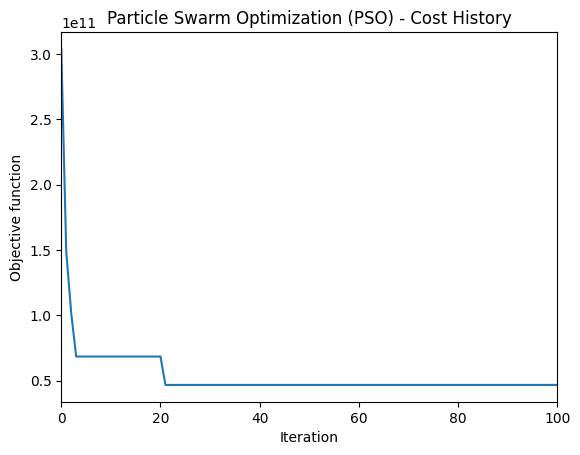

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 495226257958.71924


In [75]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

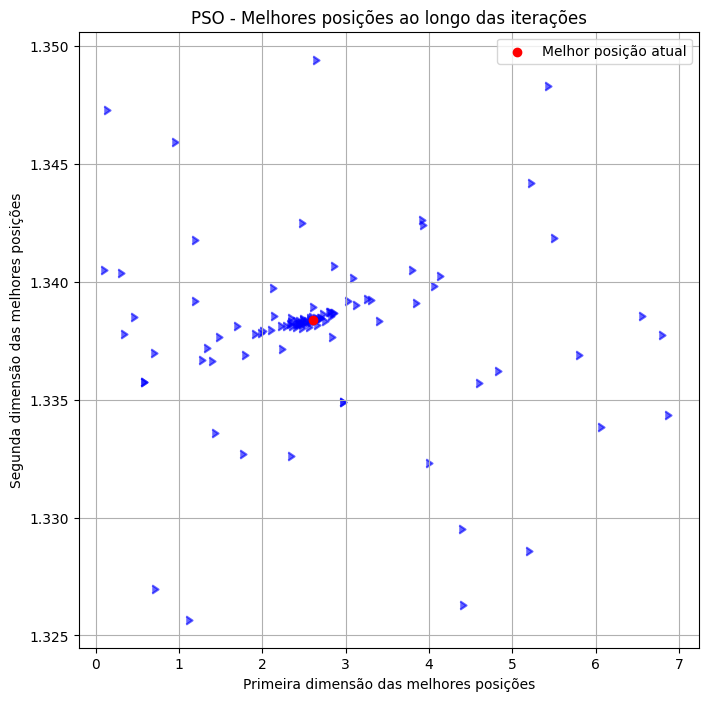

In [76]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker=m, c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()